In [1]:
import torch
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 24.1 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!pip install Roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [4]:
from roboflow import Roboflow


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vO200m2VEA65CSakchvR")
project = rf.workspace("plant-disease-detection-89qrx").project("plant-disease-detection-znzrh")
version = project.version(8)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plant-disease-detection-8 in yolov8:: 100%|██████████| 58036/58036 [00:11<00:00, 5193.24it/s]


In [6]:
def apply_clahe(image_path, clip_limit=2.0, grid_size=(8, 8)):
    """Apply CLAHE to enhance contrast of the input image."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)

    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    l_clahe = clahe.apply(l)

    # Merge and convert back to BGR
    img_lab_clahe = cv2.merge((l_clahe, a, b))
    img_clahe = cv2.cvtColor(img_lab_clahe, cv2.COLOR_LAB2BGR)
    return img_clahe

In [7]:
def load_yolov8_model(weights_path='/content/best.pt'):
    """Load the pre-trained YOLOv8 model."""
    model = YOLO(weights_path)
    return model

# Detect diseases using YOLOv8 model
def detect_with_yolov8(image_path, model):
    """Detect diseases using YOLOv8."""
    # Predict using YOLOv8 model
    results = model.predict(source=image_path, conf=0.5)  # Confidence threshold
    detections = results[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    confidences = results[0].boxes.conf.cpu().numpy()  # Confidence scores
    class_ids = results[0].boxes.cls.cpu().numpy()  # Class IDs (disease types)

    # Filter detections with high confidence
    filtered_detections = []
    for i, conf in enumerate(confidences):
        if conf > 0.5:  # Adjust confidence threshold as needed
            filtered_detections.append({
                "class_id": class_ids[i],
                "confidence": conf,
                "bbox": detections[i]
            })

    return filtered_detections

In [9]:
from google.colab.patches import cv2_imshow  # Import the correct function for displaying images in Colab

# Example class names (replace this with your own class names)
class_names = {
    0: 'Apple Black Rot Leaf',
    1: 'Apple Healthy Leaf',
    2: 'Apple Scab Leaf',
    3: 'Bell Pepper Bacterial Spot Leaf',
    4: 'Bell Pepper Healthy Leaf',
    5: 'Cassava Brown Streak Disease',
    6: 'Cassava Bacterial Blight',
    7: 'Cassava Green Mottle',
    8: 'Cedar Apple Rust',
    9: 'Cherry Healthy Leaf',
    10: 'Cherry Powdery Mildew Leaf',
    11: 'Corn Cercospora Leaf Spot',
    12: 'Corn Common Rust Leaf',
    13: 'Corn Healthy Leaf',
    14: 'Grape Black Rot Leaf',
    15: 'Grape Esca Leaf',
    16: 'Grape Healthy Leaf',
    17: 'Grape Leaf Blight',
    18: 'Cassava Healthy Leaf',
    19: 'Cassava Mosaic Virus Leaf',
    20: 'Northern Leaf Blight',
    21: 'Orange Citrus Greening',
    22: 'Peach Bacterial Spot Leaf',
    23: 'Peach Healthy Leaf',
    24: 'Potato Early Blight Leaf',
    25: 'Potato Healthy Leaf',
    26: 'Potato Late Blight Leaf',
    27: 'Rice Brown Spot',
    28: 'Rice Healthy Leaf',
    29: 'Rice Hispa Leaf',
    30: 'Rice Leaf Blast',
    31: 'Spider Mites Two-Spotted Spider Mite Leaf',
    32: 'Squash Powdery Mildew Leaf',
    33: 'Strawberry Healthy Leaf',
    34: 'Strawberry Leaf Scorch',
    35: 'Tomato Bacterial Spot Leaf',
    36: 'Tomato Early Blight Leaf',
    37: 'Tomato Late Blight Leaf',
    38: 'Tomato Healthy Leaf',
    39: 'Tomato Leaf Mould',
    40: 'Tomato Septoria Leaf Spot'
}


# Draw bounding boxes on the image
def draw_bounding_boxes(image_path, predictions):
    """Draw bounding boxes on the image for detected diseases and print class names."""
    img = cv2.imread(image_path)

    for pred in predictions:
        # Ensure that the bounding box coordinates are integers
        x1, y1, x2, y2 = map(int, pred['bbox'])  # Convert bounding box coordinates to integers
        confidence = pred['confidence']
        class_id = int(pred['class_id'])  # Ensure the class ID is an integer

        # Get class name from the class ID
        class_name = class_names.get(class_id, 'Unknown')  # Default to 'Unknown' if class ID is not found

        # Draw the bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Put class name and confidence text on the image
        label = f"{class_name}: {confidence:.2f}"
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # Print the class name and confidence
        print(f"Detected: {class_name}, Confidence: {confidence:.2f}")

    # Display the image with bounding boxes using cv2_imshow
    cv2_imshow(img)






image 1/1 /content/plant-disease-detection-8/valid/images/0b13b997-9957-4029-b2a4-ef4a046eb088___UF-GRC_BS_Lab-Leaf-0595_JPG.rf.a1c899e572be7914b45851360f43e8c0.jpg: 640x640 1 tomato bacterial spot, 37.1ms
Speed: 2.1ms preprocess, 37.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Detected Diseases:
Class ID: 35.0, Confidence: 0.9270497560501099, Bounding Box: [     121.54      35.581      593.57      639.05]
Detected: Tomato Bacterial Spot Leaf, Confidence: 0.93


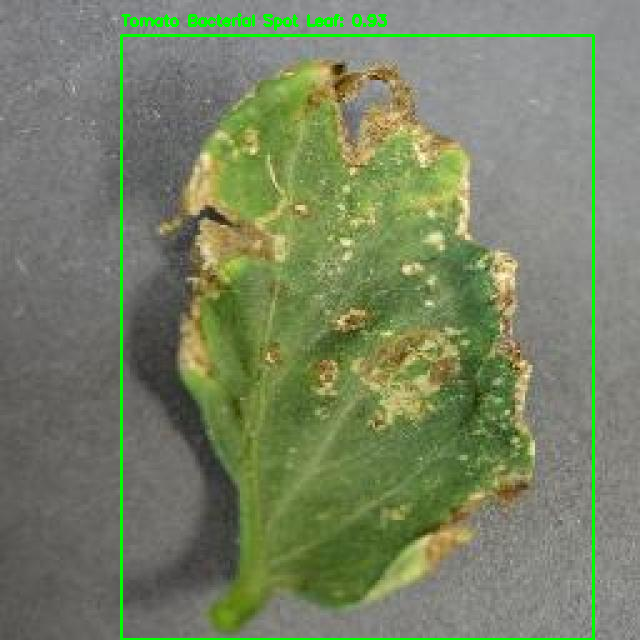

In [16]:
if __name__ == "__main__":
    # Define the image path and YOLOv8 model weights path
    image_path = "/content/plant-disease-detection-8/valid/images/0b13b997-9957-4029-b2a4-ef4a046eb088___UF-GRC_BS_Lab-Leaf-0595_JPG.rf.a1c899e572be7914b45851360f43e8c0.jpg"  # Change to your image path
    yolo_weights_path = "/content/best.pt"  # Change to your YOLOv8 model weights path

    # Load YOLOv8 model
    yolo_model = load_yolov8_model(yolo_weights_path)

    # Optional: Preprocess image with CLAHE (if you want to use it)
    preprocessed_image = apply_clahe(image_path)

    # Detect diseases using YOLOv8
    predictions = detect_with_yolov8(image_path, yolo_model)

    # Print the predictions and draw bounding boxes
    if predictions:
        print("Detected Diseases:")
        for pred in predictions:
            print(f"Class ID: {pred['class_id']}, Confidence: {pred['confidence']}, Bounding Box: {pred['bbox']}")

        # Draw bounding boxes on the image
        draw_bounding_boxes(image_path, predictions)
    else:
        print("No diseases detected with high confidence.")